In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

In [2]:
#changing the working directory
%cd /content

#Check the present working directory using pwd command

/content


In [3]:
!kaggle datasets download -d zynicide/wine-reviews

 83% 42.0M/50.9M [00:00<00:00, 58.5MB/s]
100% 50.9M/50.9M [00:00<00:00, 115MB/s] 


In [4]:
!unzip /content/wine-reviews.zip

Archive:  /content/wine-reviews.zip
  inflating: winemag-data-130k-v2.csv  
  inflating: winemag-data-130k-v2.json  
  inflating: winemag-data_first150k.csv  


In [5]:
!ls

drive	     winemag-data-130k-v2.csv	winemag-data_first150k.csv
sample_data  winemag-data-130k-v2.json	wine-reviews.zip


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from gensim.models import Word2Vec # importing Word2Vec

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Conv1D, Dropout, SpatialDropout1D, LSTM, Embedding, GlobalMaxPool1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('/content/winemag-data-130k-v2.csv')

In [8]:
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [9]:
df.shape

(129971, 14)

In [10]:
df['description'].nunique()

119955

In [11]:
duplicate = df[df.duplicated('description', keep=False)]

In [12]:
duplicate.shape

(20026, 14)

In [13]:
duplicate['description'].value_counts()

Cigar box, café au lait, and dried tobacco aromas are followed by coffee and cherry flavors, with barrel spices lingering on the finish. The wood gets a bit out front but it still delivers enjoyment.                                                                                                          3
Gravenstein apple, honeysuckle and jasmine aromas show on the relatively boisterous nose of this bottling from a large vineyard on Highway 46 east of Paso Robles. There is compellingly grippy texture to the sip, with ripe flavors of pear and honeydew melon. A salty acidity takes it to the next level.    3
Stalky aromas suggest hay and green herbs, with raspberry in the backdrop. It's hot and short in terms of mouthfeel, with herbal flavors leading the way and berry fruit running behind. Dry red fruit and herbal notes dominate the finish.                                                                     3
This zesty red has pretty aromas that suggest small red berry, blue flower and 

In [14]:
vardescr = df[df.duplicated(['description', 'variety'],keep=False)]

In [15]:
vardescr.shape

(20008, 14)

In [16]:
duplicate[duplicate[['description', 'variety']].eq(vardescr[['description', 'variety']]).all(axis=1)==False]

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
16162,16162,Italy,This opens with subtle aromas of wild flower a...,Ventidue,93,35.0,Southern Italy,Fiano di Avellino,NaN,Kerin O’Keefe,@kerinokeefe,Villa Raiano 2014 Ventidue (Fiano di Avellino),Fiano,Villa Raiano
21810,21810,Italy,"Vibrant and spicy, this savory red delivers ar...",Grotta Rossa,89,14.0,Sicily & Sardinia,Carignano del Sulcis,NaN,Kerin O’Keefe,@kerinokeefe,Cantina Santadi 2012 Grotta Rossa (Carignano ...,Carignano,Cantina Santadi
26490,26490,Italy,This opens with subtle aromas of wild flower a...,Vigne di Sande,87,NaN,Veneto,Soave,NaN,Kerin O’Keefe,@kerinokeefe,Villa Canestrari 2016 Vigne di Sande (Soave),Garganega,Villa Canestrari
31584,31584,Italy,"Vibrant and spicy, this savory red delivers ar...",Costera,90,18.0,Sicily & Sardinia,Cannonau di Sardegna,NaN,Kerin O’Keefe,@kerinokeefe,Argiolas 2013 Costera (Cannonau di Sardegna),Red Blend,Argiolas
33110,33110,Argentina,"Stalky aromas suggest hay and green herbs, wit...",Finca La Niña,84,10.0,Mendoza Province,Mendoza,NaN,Michael Schachner,@wineschach,Don Cristobal 1492 2010 Finca La Niña Cabernet...,Cabernet Sauvignon,Don Cristobal 1492
33463,33463,Greece,"Aromas of citrus, melon and orange blossom sta...",NaN,88,15.0,Atalanti Valley,NaN,NaN,Susan Kostrzewa,@suskostrzewa,Hatzimichalis 2015 Chardonnay (Atalanti Valley),Chardonnay,Hatzimichalis
36475,36475,Italy,"Green bell pepper, red currant and dark spice ...",NaN,85,NaN,Northeastern Italy,Collio,NaN,Kerin O’Keefe,@kerinokeefe,Ca'Ronesca 2013 Pinot Nero (Collio),Pinot Nero,Ca'Ronesca
37160,37160,Italy,The subdued nose eventually reveals black cher...,Marchese Montefusco,85,10.0,Sicily & Sardinia,Terre Siciliane,NaN,Kerin O’Keefe,@kerinokeefe,Cantine Ermes 2014 Marchese Montefusco Nero d'...,Nero d'Avola,Cantine Ermes
51315,51315,Australia,In 2009 this single vineyard offering includes...,Noble Baron,90,50.0,South Australia,Barossa,NaN,Joe Czerwinski,@JoeCz,Château Tanunda 2007 Noble Baron Cabernet Sauv...,Cabernet Sauvignon,Château Tanunda
52601,52601,Italy,This offers aromas and flavors suggesting unri...,Vermentino del marchese,85,20.0,Sicily & Sardinia,Sicilia,NaN,Kerin O’Keefe,@kerinokeefe,Marchesi De Gregorio 2015 Vermentino del march...,White Blend,Marchesi De Gregorio


In [17]:
df.isna().sum()

Unnamed: 0                   0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

In [18]:
top40df = pd.DataFrame(df['variety'].value_counts().head(20))

In [19]:
top40df

,variety
Pinot Noir,13272
Chardonnay,11753
Cabernet Sauvignon,9472
Red Blend,8946
Bordeaux-style Red Blend,6915
Riesling,5189
Sauvignon Blanc,4967
Syrah,4142
Rosé,3564
Merlot,3102


In [20]:
newdf = df[df['variety'].isin(top40df.index)]

In [21]:
# threshold of miniority variety to over sample (use sentences as document instead of the whole description)
minority_threshold = 5000 

# making a dataframe of the miniority classes
minority_df = newdf[newdf['variety'].isin(top40df[top40df <  minority_threshold].dropna().index)]
print(minority_df.shape)
print(len(minority_df['variety'].unique()))
minority_df.head(2)

(38367, 14)
14


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


In [22]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
from nltk.tokenize import sent_tokenize # importing useful library

In [24]:
oversampled_miniority_lst = [] # empty list to store sentences as tokens miniority corpus

# creating a function to use sentences as tokens for the miniority classes
def over_sample_miniority(row):
    doc_list = sent_tokenize(row['description'])
    for sent in doc_list:
        row['description'] = sent
        oversampled_miniority_lst.append(list(row))

In [25]:
minority_df.apply(over_sample_miniority, axis=1); # over sample the miniority classes

In [26]:
oversampled_miniority_lst[:4]

[[0,
  'Italy',
  'Aromas include tropical fruit, broom, brimstone and dried herb.',
  'Vulkà Bianco',
  87,
  nan,
  'Sicily & Sardinia',
  'Etna',
  nan,
  'Kerin O’Keefe',
  '@kerinokeefe',
  'Nicosia 2013 Vulkà Bianco  (Etna)',
  'White Blend',
  'Nicosia'],
 [0,
  'Italy',
  "The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",
  'Vulkà Bianco',
  87,
  nan,
  'Sicily & Sardinia',
  'Etna',
  nan,
  'Kerin O’Keefe',
  '@kerinokeefe',
  'Nicosia 2013 Vulkà Bianco  (Etna)',
  'White Blend',
  'Nicosia'],
 [1,
  'Portugal',
  'This is ripe and fruity, a wine that is smooth while still structured.',
  'Avidagos',
  87,
  15.0,
  'Douro',
  nan,
  nan,
  'Roger Voss',
  '@vossroger',
  'Quinta dos Avidagos 2011 Avidagos Red (Douro)',
  'Portuguese Red',
  'Quinta dos Avidagos'],
 [1,
  'Portugal',
  'Firm tannins are filled out with juicy red berry fruits and freshened with acidity.',
  'Avidagos',
  87,
  15.0,
  'Douro',
  nan

In [27]:
# converts oversampled_miniority_lst to a dataframe
oversampled_miniority_df = pd.DataFrame(oversampled_miniority_lst, columns=minority_df.columns)
print(oversampled_miniority_df.shape)
oversampled_miniority_df.head(2)

(104101, 14)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,0,Italy,"The palate isn't overly expressive, offering u...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


In [28]:


# selecting majority classes as a dataframe to concatenate to oversampled_miniority_lst
majority_df = newdf[newdf['variety'].isin(top40df[top40df >= minority_threshold].dropna().index)]

# concatenates majority_df to oversampled_miniority_lst
balanced_df = pd.concat([majority_df, oversampled_miniority_df]) 
balanced_df = balanced_df.reset_index().drop('index', axis=1) # resets index
print(balanced_df.shape)
balanced_df.head(2)



(159648, 14)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
1,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [29]:
balanced_df.drop('Unnamed: 0', inplace=True, axis=1)

In [30]:
balanced_df.isna().sum()

country                     69
description                  0
designation              43512
points                       0
price                     9325
province                    69
region_1                 25858
region_2                 95561
taster_name              30409
taster_twitter_handle    35171
title                        0
variety                      0
winery                       0
dtype: int64

In [31]:
balanced_df['country'].replace({'US':'United States of America'}, inplace=True)

In [32]:
balanced_df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,United States of America,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
1,United States of America,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
2,United States of America,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
3,United States of America,"Slightly reduced, this wine offers a chalky, t...",NaN,87,34.0,California,Alexander Valley,Sonoma,Virginie Boone,@vboone,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini
4,United States of America,Building on 150 years and six generations of w...,NaN,87,12.0,California,Central Coast,Central Coast,Matt Kettmann,@mattkettmann,Mirassou 2012 Chardonnay (Central Coast),Chardonnay,Mirassou


In [33]:
balanced_variety = balanced_df['variety'].value_counts() # gets a Series of the variety count in balanced_df
balanced_variety

Pinot Noir                  13272
Sauvignon Blanc             12801
Chardonnay                  11753
Syrah                       11128
Cabernet Sauvignon           9472
Rosé                         9207
Red Blend                    8946
Nebbiolo                     8107
Malbec                       8047
Merlot                       7874
Portuguese Red               7734
Sangiovese                   7432
Bordeaux-style Red Blend     6915
Zinfandel                    6512
White Blend                  6034
Sparkling Blend              5740
Tempranillo                  5552
Riesling                     5189
Rhône-style Red Blend        3972
Pinot Gris                   3961
Name: variety, dtype: int64

In [34]:
newdf = balanced_df.copy()

In [35]:
newdf.fillna('', inplace=True)

In [36]:
balanced_df['not vintage'] = newdf['country'] + ' ' + newdf['designation'] + ' ' + newdf['province']\
   + ' ' + newdf['region_1'] + ' ' + newdf['region_2'] + ' ' + newdf['winery']

In [37]:
balanced_df['sentences'] = balanced_df['description'] + ' ' + balanced_df['not vintage']

In [81]:
balanced_df.head(2)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,not vintage,sentences
0,United States of America,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,United States of America Reserve Late Harvest ...,"Pineapple rind, lemon pith and orange blossom ..."
1,United States of America,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,United States of America Vintner's Reserve Wil...,"Much like the regular bottling from 2012, this..."


# Loading spacy

In [39]:
nlp = spacy.load('en', disable=['tagger', 'parser', 'ner'])
spacy_stop_words = spacy.lang.en.STOP_WORDS # getting spacy's stop-words

In [40]:
#Stopwords list from https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js
# Convert it to a Python list and paste it here
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [41]:
type(spacy_stop_words)

set

In [43]:
odd_stop = ['-pron-', '10', '12', 'aah', 'aa', 'ab', 'aaa', 'aand', '16', '2', '20', '30', '4', '40', '5', '6', '7', '8', '9']

In [44]:
stop_words_lemma = {word.lemma_.lower() for word in nlp(' '.join(stopwords))}

In [45]:
stopwords = list(set(list(spacy_stop_words) + stopwords + odd_stop + list(stop_words_lemma)))

In [46]:
# defining tokenzer function to tokenize the lower case lemma of documents in a corpus and 
# filter out stop-words  
def tokenizer_spacy(text):
    return [word.lemma_.lower() for word in nlp(text) if word.is_alpha and word.lemma_.lower() not in stopwords]



In [47]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold

In [48]:
sentences = balanced_df['sentences']
labels = balanced_df['variety']

In [49]:
encode = LabelEncoder()
labels = encode.fit_transform(labels)

In [144]:
embedding_dim = 300
max_length = 90
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

senten = []

for sentence in sentences:
  for word in stopwords:
    token = " " + word + " "
    sentence = sentence.lower().replace(token, " ")
    sentence = sentence.replace("  ", " ")
    sentence = sentence.replace("\xa0", " ")
  senten.append(sentence)

senten = [word for word in senten if word not in stopwords]

In [145]:
# tokenize (lemmatize and filter stop words) corpus 
senten = [' '.join(tokenizer_spacy(doc)) for doc in senten]

In [146]:
balanced_df['sentences'][:2].iloc[0]

'Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish. United States of America Reserve Late Harvest Michigan Lake Michigan Shore  St. Julian'

In [147]:
senten[0]

'pineapple rind lemon pith orange blossom start aroma palate bite opulent note honey drizzle guava mango way slightly astringent semidry finish unite state america reserve late harvest michigan lake michigan shore st julian'

In [148]:
sentences[:2].iloc[0]

'Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish. United States of America Reserve Late Harvest Michigan Lake Michigan Shore  St. Julian'

In [149]:
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(senten)

word_index = tokenizer.word_index

In [150]:
vocab_size = len(word_index)

In [151]:
vocab_size

37725

In [152]:
training_sequences = tokenizer.texts_to_sequences(senten)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [153]:
senten_corpus = tokenizer.sequences_to_texts(training_sequences)

In [154]:
senten_corpus[-3:]

['weight solid powerful core spice bake apple flavor france alsace alsace domaine marcel deiss',
 'structure develope wine need age france alsace alsace domaine marcel deiss',
 'drink france alsace alsace domaine marcel deiss']

In [155]:
senten_corpus[:2]

['pineapple rind lemon pith orange blossom start aroma palate bite opulent note honey drizzle guava mango way slightly astringent semidry finish unite state america reserve late harvest michigan lake michigan shore st julian',
 'like regular bottle come rough tannic rustic earthy herbal characteristic nonetheless think pleasantly unfussy country wine good companion hearty winter stew unite state america vintner reserve wild child block oregon willamette valley willamette valley sweet cheek']

In [156]:
len(senten_corpus)

159648

In [157]:
sent_oversample_corpus = [doc.split() for doc in senten_corpus] # gets corpus as a list of lists

In [158]:
sent_oversample_corpus[:2]

[['pineapple',
  'rind',
  'lemon',
  'pith',
  'orange',
  'blossom',
  'start',
  'aroma',
  'palate',
  'bite',
  'opulent',
  'note',
  'honey',
  'drizzle',
  'guava',
  'mango',
  'way',
  'slightly',
  'astringent',
  'semidry',
  'finish',
  'unite',
  'state',
  'america',
  'reserve',
  'late',
  'harvest',
  'michigan',
  'lake',
  'michigan',
  'shore',
  'st',
  'julian'],
 ['like',
  'regular',
  'bottle',
  'come',
  'rough',
  'tannic',
  'rustic',
  'earthy',
  'herbal',
  'characteristic',
  'nonetheless',
  'think',
  'pleasantly',
  'unfussy',
  'country',
  'wine',
  'good',
  'companion',
  'hearty',
  'winter',
  'stew',
  'unite',
  'state',
  'america',
  'vintner',
  'reserve',
  'wild',
  'child',
  'block',
  'oregon',
  'willamette',
  'valley',
  'willamette',
  'valley',
  'sweet',
  'cheek']]

In [159]:
# trains sent_oversample_corpus2 on Word2Vec. For sent_oversample_corpus2, min_count of 5 and iter (epoch) of 10 
# seems to be the best
sent_w2v_model = Word2Vec(sent_oversample_corpus, size=300, min_count=1, iter=10)

print(sent_w2v_model) # sumarizes the word2vec

Word2Vec(vocab=37724, size=300, alpha=0.025)


In [160]:
sent_w2v_model.wv.__getitem__('pineapple').shape # confirms the dimension of our embedding

(300,)

In [161]:
# picking out the odd word
sent_w2v_model.wv.doesnt_match(['cherry', 'italy', 'apple', 'pineapple', 'tangerine'])

'italy'

In [162]:
# picking out the odd word
sent_w2v_model.wv.doesnt_match(['arizona', 'france', 'michigan', 'texas', 'pennsylvania'])

'france'

In [163]:
# let's see a random province in Portugal
balanced_df[balanced_df['country'] == 'Portugal']['province'].unique()[0]

'Estremadura'

In [164]:
# just like king - man + woman = queen, we want to prove that portugal - estremadura + ontario = canada
print(sent_w2v_model.wv.most_similar(positive=['portugal', 'ontario'], negative=['estremadura']))

[('canada', 0.5451585650444031), ('germany', 0.4108649492263794), ('vaïla', 0.4010735750198364), ('mclean', 0.372231662273407), ('british', 0.3711729645729065), ('caronne', 0.35238224267959595), ('right', 0.3501496911048889), ('austria', 0.3487246632575989), ('vanessa', 0.33699628710746765), ('france', 0.33164799213409424)]


In [165]:
# let's see the most similar words to 'aroma'
print(sent_w2v_model.wv.most_similar('aroma'))

[('scent', 0.8007731437683105), ('bouquet', 0.6715725064277649), ('note', 0.6315639615058899), ('smell', 0.6044454574584961), ('nose', 0.5825537443161011), ('whiff', 0.5671712756156921), ('mix', 0.5607091188430786), ('fragrance', 0.5548509359359741), ('aromatic', 0.5361471772193909), ('recall', 0.533400297164917)]


In [166]:
len(sent_w2v_model.wv.vocab)

37724

In [167]:
# Using set()
def Diff(li1, li2):
    return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))
 
# Driver Code
li1 = list(sent_w2v_model.wv.vocab.keys())
li2 = list(word_index.keys())
print(Diff(li1, li2))

['<OOV>']


# Modelling

Defining a function that creates an embedding matrix

In [168]:
def get_embedding_matrix(model, word_index):
    vocab_size = len(word_index) + 1
    embedding_dim = model.wv.vector_size
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    for word in model.wv.vocab:
        ind = word_index[word]
        embedding_matrix[ind] = model[word]
        
    return embedding_matrix

In [169]:
embedding_matrix = get_embedding_matrix(sent_w2v_model, word_index)

In [170]:
embedding_matrix.shape

(37726, 300)

In [256]:
def nlp_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length,  mask_zero=True, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(250)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation='softmax')
  ])

  model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

  return model

In [257]:
model = nlp_model()
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, 90, 300)           11317800  
_________________________________________________________________
dropout_37 (Dropout)         (None, 90, 300)           0         
_________________________________________________________________
bidirectional_42 (Bidirectio (None, 500)               1102000   
_________________________________________________________________
dropout_38 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 20)                10020     
Total params: 12,429,820
Trainable params: 1,112,020
Non-trainable params: 11,317,800
_________________________________________________________________


In [258]:
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(labels), class_weight.compute_class_weight('balanced',
                                                 np.unique(labels),
                                                 labels))) 

In [259]:
training_padded = np.array(training_padded)


num_epochs = 20

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               min_delta=1e-4)
lrp = tf.keraslrp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.1,
                                   patience=2,
                                   cooldown=2,
                                   verbose=1)


history = model.fit(training_padded, labels, epochs=num_epochs, class_weight=class_weights, 
                    validation_split=0.25,
                    batch_size=128, verbose=1,
                    callbacks=[early_stopping, lrp])

Epoch 1/20
936/936 [==============================] - 28s 30ms/step - loss: 0.7161 - accuracy: 0.7621 - val_loss: 0.6921 - val_accuracy: 0.7761
Epoch 2/20
936/936 [==============================] - 26s 28ms/step - loss: 0.5031 - accuracy: 0.8272 - val_loss: 0.6357 - val_accuracy: 0.7932
Epoch 3/20
936/936 [==============================] - 26s 28ms/step - loss: 0.4538 - accuracy: 0.8432 - val_loss: 0.6061 - val_accuracy: 0.7997
Epoch 4/20
936/936 [==============================] - 26s 28ms/step - loss: 0.4195 - accuracy: 0.8533 - val_loss: 0.5833 - val_accuracy: 0.8105
Epoch 5/20
936/936 [==============================] - 27s 29ms/step - loss: 0.3961 - accuracy: 0.8611 - val_loss: 0.5817 - val_accuracy: 0.8123
Epoch 6/20
936/936 [==============================] - 27s 28ms/step - loss: 0.3780 - accuracy: 0.8662 - val_loss: 0.5745 - val_accuracy: 0.8160
Epoch 7/20
936/936 [==============================] - 27s 28ms/step - loss: 0.3607 - accuracy: 0.8706 - val_loss: 0.5584 - val_accuracy:

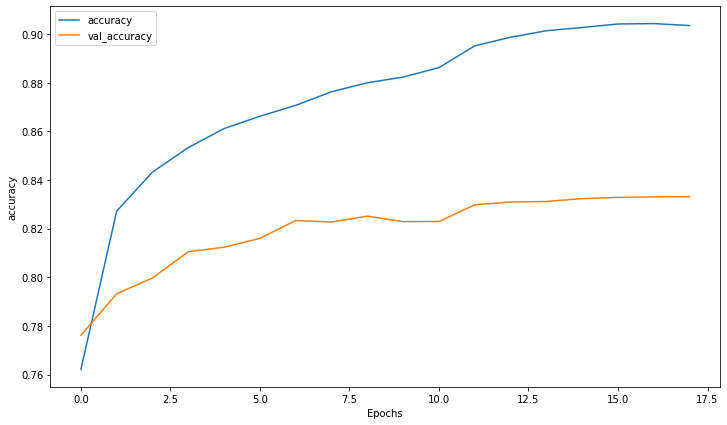

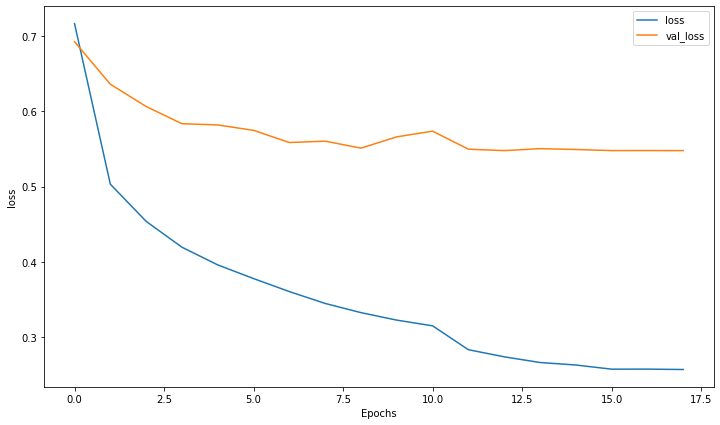

In [260]:
def plot_graphs(history, string):
  plt.figure(figsize=(12,7))
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [261]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

In [262]:
model2 = KerasClassifier(build_fn=nlp_model) # build model

In [263]:
# creating a RepeatedStratifiedKFold object. Since we plan using 25% as our test-size, we will use 4 fold cv.
# to have a level plain ground for comparing different models, we will be using random state of 1 through out.
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=1)

In [264]:
# getting cross validation scores
score = cross_val_score(model2, training_padded, labels, scoring='f1_weighted', cv=cv,\
                        n_jobs=1, verbose=2, fit_params={\
                        'epochs': 7, 'batch_size': 128, 'class_weight': class_weights, 'verbose': 0, \
                                                        })

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total= 2.7min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


[CV] ................................................. , total= 2.7min
[CV]  ................................................................
[CV] ................................................. , total= 2.7min
[CV]  ................................................................
[CV] ................................................. , total= 2.7min
[CV]  ................................................................
[CV] ................................................. , total= 2.7min
[CV]  ................................................................
[CV] ................................................. , total= 2.7min
[CV]  ................................................................
[CV] ................................................. , total= 2.7min
[CV]  ................................................................
[CV] ................................................. , total= 2.7min
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 32.8min finished


In [265]:
print(score)
np.mean(score) # reporting the mean score

[0.86541072 0.86390355 0.86631223 0.86363147 0.86452971 0.86657303
 0.8649578  0.86553129 0.86774611 0.86644015 0.86623817 0.86556372]


0.8655698303196928

# Trying Other means

In [266]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(training_padded, labels, \
                                                    test_size=0.25, random_state=1)

In [272]:
model2 = nlp_model() # builds model

In [310]:
model2.fit(X_train, y_train,
                    epochs=5, # using the best epoch from model1
                    verbose=True,
                    batch_size=128,
                    class_weight=class_weights)

Epoch 1/5
936/936 [==============================] - 24s 25ms/step - loss: 0.3759 - accuracy: 0.8647
Epoch 2/5
936/936 [==============================] - 23s 25ms/step - loss: 0.3676 - accuracy: 0.8677
Epoch 3/5
936/936 [==============================] - 23s 25ms/step - loss: 0.3568 - accuracy: 0.8709
Epoch 4/5
936/936 [==============================] - 23s 25ms/step - loss: 0.3491 - accuracy: 0.8736
Epoch 5/5
936/936 [==============================] - 23s 25ms/step - loss: 0.3410 - accuracy: 0.8762


In [311]:
loss, accuracy = model2.evaluate(X_train, y_train, batch_size=128, verbose=False)
print('Training Accuracy: {:.4f}\nTraining loss: {:.4f}'.format(accuracy, loss))
print()
loss, accuracy = model2.evaluate(X_test, y_test, batch_size=128, verbose=False)
print('Testing Accuracy: {:.4f}\nTesting loss: {:.4f}'.format(accuracy, loss))

Training Accuracy: 0.9173
Training loss: 0.2377

Testing Accuracy: 0.8772
Testing loss: 0.3820


In [297]:
user_input = ["This deeply refreshing White Blend starts with a fine California wine that undergoes a secondary fermentation with pineapple juice. The result is a vibrant, light-bodied wine style with notes of fresh pineapple and other tropical fruits and a crisp finish."]

In [298]:
# converting texts to numbers
test1 = tokenizer.texts_to_sequences(user_input)
test1_padded = pad_sequences(test1, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [306]:
test1pred = model.predict(test1_padded)

In [307]:
test1pred

array([[2.09754708e-05, 3.72640170e-05, 9.80693638e-01, 1.71310681e-08,
        1.38594558e-07, 1.70136308e-10, 1.17759377e-07, 1.03562861e-05,
        5.22521637e-10, 1.31258322e-03, 8.83384388e-08, 2.55559862e-04,
        2.31805711e-06, 6.94250218e-07, 1.13733906e-04, 2.05769357e-08,
        1.70330736e-07, 5.64578045e-07, 1.75517313e-02, 4.23132818e-08]],
      dtype=float32)

In [308]:
encode.inverse_transform([np.argmax(test1pred)])

array(['Chardonnay'], dtype=object)

In [309]:
encode.inverse_transform([18])

array(['White Blend'], dtype=object)